#### Remember, you only need to run this once, and then you will have various .csv saved you can pull directly and examine...

<br>

# Sensor Analysis

#### Examining filtering techniques and using Dask 

In [9]:

#  Purpose:
#
#    - Read in huge dataframe via Dask, and then filter to a single sensor's data
#      for initial examination and ML building
#
#    - Determine optimal way to read in 122 sensors unique 
#
#    - Remember:  We have a massive file we are reading from (340GB), can't store it on github... 
#


In [10]:

# libraries
import os
import matplotlib.pyplot as plt
%matplotlib inline

import dask 
import dask.dataframe as dd
from dask.distributed import Client, progress
import pandas as pd 
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
import numpy as np


In [11]:

%pwd


'D:\\CRITICAL_MAIN_DATAFILE__MILESTONE_II\\AoT_Chicago.complete.2021-09-12'

######  Must move to main folder where massive dataset is located...

In [12]:

%cd D:\CRITICAL_MAIN_DATAFILE__MILESTONE_II\AoT_Chicago.complete.2021-09-12
    

D:\CRITICAL_MAIN_DATAFILE__MILESTONE_II\AoT_Chicago.complete.2021-09-12


In [13]:

%pwd


'D:\\CRITICAL_MAIN_DATAFILE__MILESTONE_II\\AoT_Chicago.complete.2021-09-12'

In [14]:

%ls 


 Volume in drive D is New Volume
 Volume Serial Number is A060-E317

 Directory of D:\CRITICAL_MAIN_DATAFILE__MILESTONE_II\AoT_Chicago.complete.2021-09-12

09/15/2021  08:21 PM    <DIR>          .
09/15/2021  08:21 PM    <DIR>          ..
09/14/2021  03:20 PM    <DIR>          .ipynb_checkpoints
09/14/2021  03:23 PM         2,458,687 003_filtering_data_for_single_sensor.ipynb
09/13/2021  04:12 PM         3,298,171 DASK_reading_huge_data_file.ipynb
09/14/2021  03:03 PM         2,460,060 DASK_reading_huge_data_file-II.ipynb
09/16/2021  08:05 PM    <DIR>          dask-worker-space
09/11/2021  08:20 PM   311,296,394,924 data.csv
09/11/2021  08:20 PM    36,218,598,776 data.csv.gz
09/13/2021  01:20 PM       263,395,639 exported_dataframe.csv
09/15/2021  05:08 PM        56,381,791 high_resolution_1.html
09/15/2021  05:26 PM        56,381,789 high_resolution_2.html
09/11/2021  08:20 PM            16,268 nodes.csv
09/11/2021  08:20 PM            42,812 offsets.csv
09/11/2021  08:20 PM          

<br>

---

<br>


## Examining huge dataset

### Using Dask 

In [15]:

# file size 

! dir data.csv   

# 311,296,394,924 bytes ~ 320 GB 


 Volume in drive D is New Volume
 Volume Serial Number is A060-E317

 Directory of D:\CRITICAL_MAIN_DATAFILE__MILESTONE_II\AoT_Chicago.complete.2021-09-12

09/11/2021  08:20 PM   311,296,394,924 data.csv
               1 File(s) 311,296,394,924 bytes
               0 Dir(s)  913,977,356,288 bytes free


In [16]:

# client = Client(n_workers=4, threads_per_worker=2, memory_limit='2GB')

client = Client()

client


C:\Users\tbresee\Anaconda3\lib\site-packages\distributed\node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 54078 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:54078/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:54078/status,Workers: 6
Total threads: 24,Total memory: 63.95 GiB
Comm: tcp://127.0.0.1:54081,Workers: 6
Dashboard: http://127.0.0.1:54078/status,Total threads: 24
Started: Just now,Total memory: 63.95 GiB
Comm: tcp://127.0.0.1:54123,Total threads: 4
Dashboard: http://127.0.0.1:54125/status,Memory: 10.66 GiB
Nanny: tcp://127.0.0.1:54086,


In [17]:

print(client)


<Client: 'tcp://127.0.0.1:54081' processes=6 threads=24, memory=63.95 GiB>


In [18]:

client.status


'running'

In [20]:

client.has_what()


Worker,Key count,Key list
tcp://127.0.0.1:54119,0,Expand
tcp://127.0.0.1:54122,0,Expand
tcp://127.0.0.1:54123,0,Expand
tcp://127.0.0.1:54128,0,Expand
tcp://127.0.0.1:54131,0,Expand
tcp://127.0.0.1:54134,0,Expand


In [21]:

client.dashboard_link


'http://127.0.0.1:54078/status'

In [22]:

type(client)


distributed.client.Client

In [23]:

# from dask import dataframe as dd
# start = time.time()
# dask_df = dd.read_csv('huge_data.csv')
# end = time.time()
# print("Read csv with dask: ",(end-start),"sec")
# Read csv with dask:  0.07900428771972656 sec
    


* Why DASK is better than PANDAS?
Pandas utilizes a single CPU core while Dask utilizes multiple CPU cores by internally chunking dataframe and process in parallel. In simple words, multiple small dataframes of a large dataframe got processed at a time wherein under pandas, operating a single large dataframe takes a long time to run.
DASK can handle large datasets on a single CPU exploiting its multiple cores or cluster of machines refers to distributed computing. It provides a sort of scaled pandas and numpy libraries.
Not only dataframe, dask also provides array and scikit-learn libraries to exploit parallelism.
`

* “Partitions” here simply mean the number of Pandas dataframes split within the Dask dataframe.
The more partitions we have, the more tasks we will need for each computation.`m

In [24]:

filename = 'data.csv'

df = dd.read_csv(filename,  dtype={'value_raw': 'object'})

# add later:    .set_index('timestamp')
# assume_missing=True, )
# dtype={'value_raw': 'float64'})
# dtype={'value_hrf': 'float64', 
#         'value_raw': 'float64'}, 
# parse_dates=['timestamp'])              

# DONT NEED:  df = df.set_index('timestamp')
    

In [26]:
type(df)

dask.dataframe.core.DataFrame

In [25]:

df.dtypes # dtypes will be adjusted 


timestamp    object
node_id      object
subsystem    object
sensor       object
parameter    object
value_raw    object
value_hrf    object
dtype: object

In [ ]:

#  df['timestamp'] = pd.to_datetime(df['timestamp'])
# df['Date'] = df['Date'].astype('datetime64[ns]')


In [27]:

df.columns


Index(['timestamp', 'node_id', 'subsystem', 'sensor', 'parameter', 'value_raw',
       'value_hrf'],
      dtype='object')

In [28]:

# parse_dates=['Date']

# df = df.astype({"timestamp": object, 
#                 "node_id": object, 
#                 "subsystem": object, 
#                 "sensor": object, 
#                 "parameter": object, 
#                 "value_raw": float, 
#                 "value_hrf": float})


In [29]:

df.head(50)


,timestamp,node_id,subsystem,sensor,parameter,value_raw,value_hrf
0,2018/01/01 00:00:06,001e0610e532,chemsense,at0,temperature,-1106,-11.06
1,2018/01/01 00:00:06,001e0610e532,chemsense,at1,temperature,-1077,-10.77
2,2018/01/01 00:00:06,001e0610e532,chemsense,at2,temperature,-1009,-10.09
3,2018/01/01 00:00:06,001e0610e532,chemsense,at3,temperature,-972,-9.72
4,2018/01/01 00:00:06,001e0610e532,chemsense,chemsense,id,NaN,541eec3ebfa6
5,2018/01/01 00:00:06,001e0610e532,chemsense,co,concentration,2068,NaN
6,2018/01/01 00:00:06,001e0610e532,chemsense,h2s,concentration,-345,NaN
7,2018/01/01 00:00:06,001e0610e532,chemsense,lps25h,pressure,101939,1019.39
8,2018/01/01 00:00:06,001e0610e532,chemsense,lps25h,temperature,-954,-9.54
9,2018/01/01 00:00:06,001e0610e532,chemsense,no2,concentration,649,NaN


In [30]:

df.tail(50)


,timestamp,node_id,subsystem,sensor,parameter,value_raw,value_hrf
5213,2021/03/22 05:18:17,001e0610ee36,lightsense,hmc5883l,magnetic_field_z,-478,-487.755
5214,2021/03/22 05:18:17,001e0610ee36,lightsense,ml8511,intensity,9587,43.501
5215,2021/03/22 05:18:17,001e0610ee36,lightsense,mlx75305,intensity,1074,10.782
5216,2021/03/22 05:18:17,001e0610ee36,lightsense,tmp421,temperature,5760,22.5
5217,2021/03/22 05:18:17,001e0610ee36,lightsense,tsl250rd,intensity,9586,23.313
5218,2021/03/22 05:18:17,001e0610ee36,lightsense,tsl260rd,intensity,1074,2.786
5219,2021/03/22 05:18:17,001e0610ee36,metsense,bmp180,pressure,11169280,1040.19
5220,2021/03/22 05:18:17,001e0610ee36,metsense,bmp180,temperature,22998,16.4
5221,2021/03/22 05:18:17,001e0610ee36,metsense,hih4030,humidity,398,60.58
5222,2021/03/22 05:18:17,001e0610ee36,metsense,htu21d,humidity,23526,38.87


In [ ]:

#  len(df)   4 195 104 977  # over four billion rows of information ... holy moly 


In [31]:

df.visualize


<bound method DaskMethodsMixin.visualize of Dask DataFrame Structure:
                 timestamp node_id subsystem  sensor parameter value_raw value_hrf
npartitions=4865                                                                  
                    object  object    object  object    object    object    object
                       ...     ...       ...     ...       ...       ...       ...
...                    ...     ...       ...     ...       ...       ...       ...
                       ...     ...       ...     ...       ...       ...       ...
                       ...     ...       ...     ...       ...       ...       ...
Dask Name: read-csv, 4865 tasks>

In [32]:

df.memory_usage()


Dask Series Structure:
npartitions=1
    int64
      ...
dtype: int64
Dask Name: series-groupby-sum-agg, 20159 tasks

In [33]:

df.describe()


,timestamp,node_id,subsystem,sensor,parameter,value_raw,value_hrf
npartitions=1,,,,,,,
,object,object,object,object,object,object,object
,...,...,...,...,...,...,...


In [34]:

df.npartitions
# huge number of partitions 


4865

In [ ]:

# this is an example of a superfilter
# temp_df = df[ (df['sensor']=='hih6130') & (df['node_id']=='001e0610e532') & (df['subsystem']=='lightsense2') & (df['parameter']=='temperature') ]


<br>

---

<br>


### Grab random sensor to begin with

In [35]:

single_sensor = df[ (df['node_id']=='001e0610ee36') ]
# if you 'compute' this, it will then be a pandas df, and then you can export...


In [36]:

type(single_sensor)


dask.dataframe.core.DataFrame

In [37]:

# you could 'compute' to examine a single dataframe pandas, 
# but ill keep as dask and directly export as csv for clarity

single_sensor.to_csv('single_sensor_exported_dask_dataframe_final.csv', single_file=True)


C:\Users\tbresee\Anaconda3\lib\statistics.py:168: RuntimeWarning: overflow encountered in long_scalars
  partials[d] = partials_get(d, 0) + n


['D:/CRITICAL_MAIN_DATAFILE__MILESTONE_II/AoT_Chicago.complete.2021-09-12/single_sensor_exported_dask_dataframe_final.csv']

In [39]:
# this will be a pretty big file 

In [ ]:

# now in theory you have like a massive 8GB like CSV file


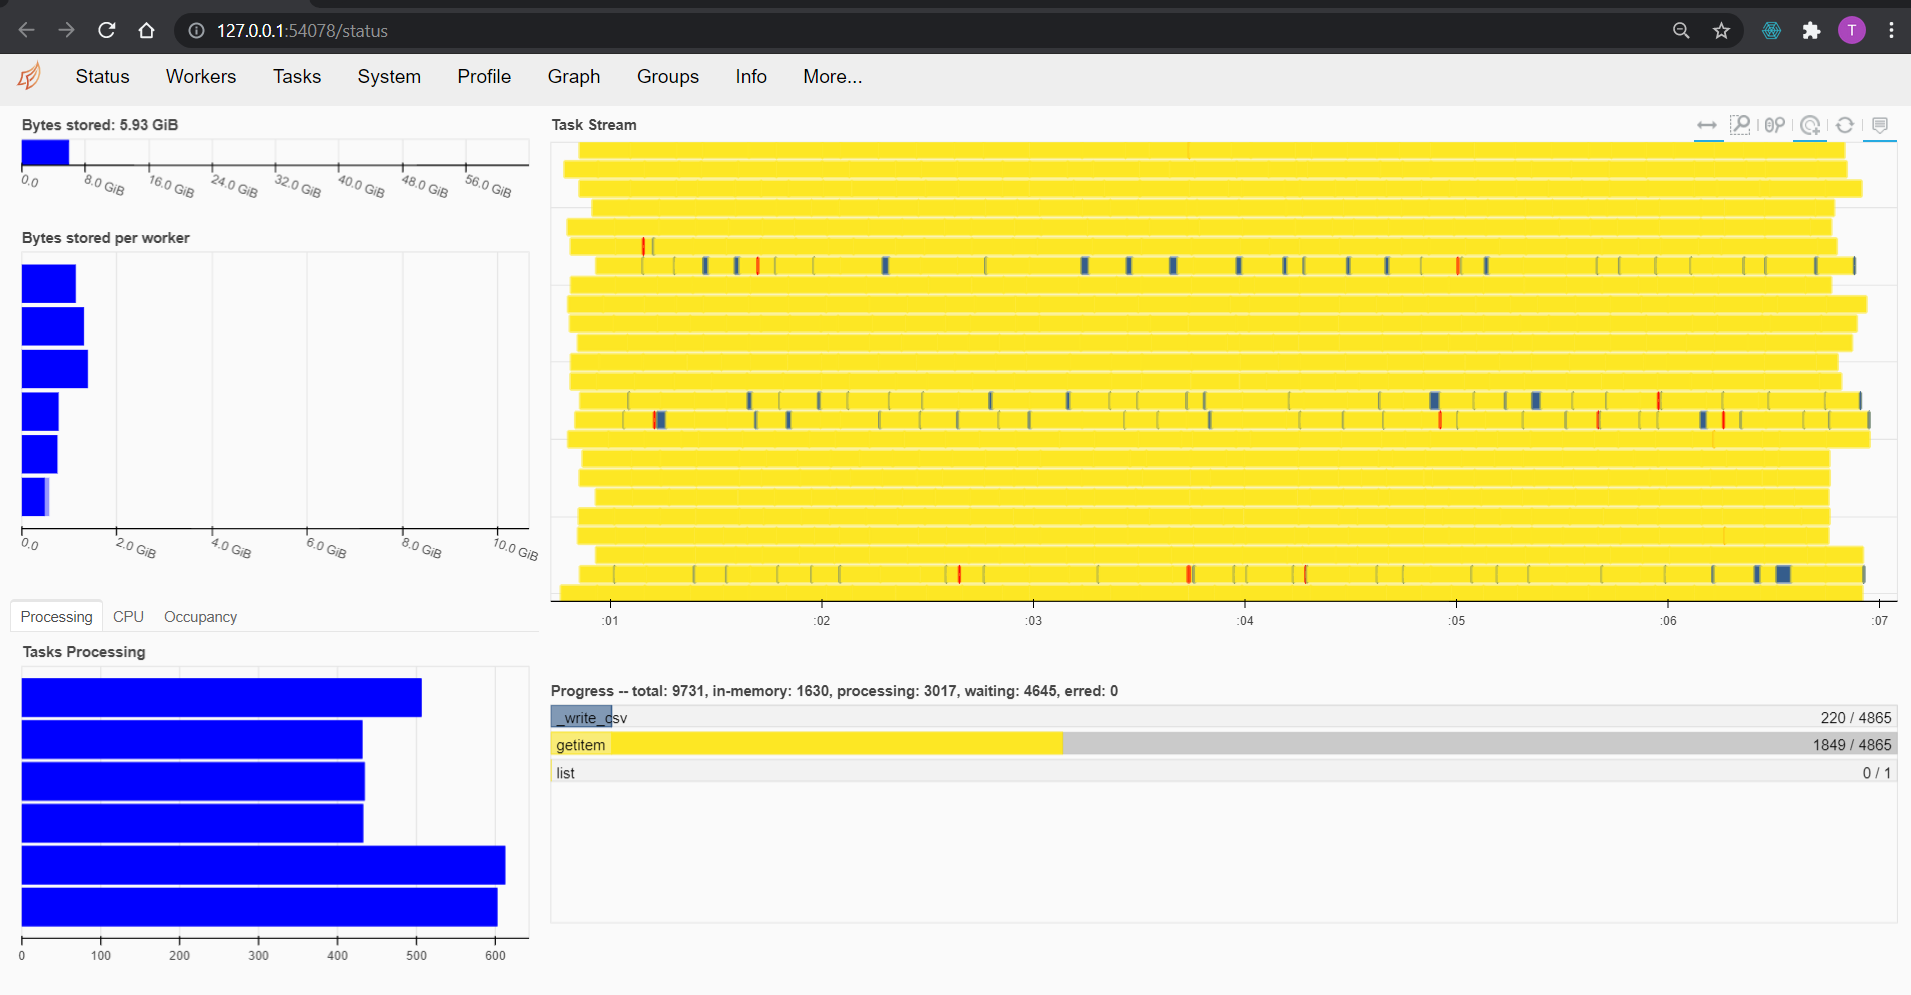

---
---
---

In [60]:
! dir 

 Volume in drive D is New Volume
 Volume Serial Number is A060-E317

 Directory of D:\CRITICAL_MAIN_DATAFILE__MILESTONE_II\AoT_Chicago.complete.2021-09-12

09/15/2021  08:21 PM    <DIR>          .
09/15/2021  08:21 PM    <DIR>          ..
09/14/2021  03:20 PM    <DIR>          .ipynb_checkpoints
09/14/2021  03:23 PM         2,458,687 003_filtering_data_for_single_sensor.ipynb
09/16/2021  08:05 PM    <DIR>          dask-worker-space
09/14/2021  03:03 PM         2,460,060 DASK_reading_huge_data_file-II.ipynb
09/13/2021  04:12 PM         3,298,171 DASK_reading_huge_data_file.ipynb
09/11/2021  08:20 PM   311,296,394,924 data.csv
09/11/2021  08:20 PM    36,218,598,776 data.csv.gz
09/13/2021  01:20 PM       263,395,639 exported_dataframe.csv
09/15/2021  05:08 PM        56,381,791 high_resolution_1.html
09/15/2021  05:26 PM        56,381,789 high_resolution_2.html
09/11/2021  08:20 PM            16,268 nodes.csv
09/11/2021  08:20 PM            42,812 offsets.csv
09/11/2021  08:20 PM          

In [55]:

single_sensor_df = pd.read_csv('single_sensor_exported_dask_dataframe_final.csv', 
                               parse_dates=['timestamp'], 
                               index_col='timestamp')


In [ ]:

# len(single_sensor_df)

# 86 169 288  # 86 million rows...
# roughly 100M rows of data 


In [ ]:

# all of this is about a single sensor...


In [56]:

single_sensor_df.head(20)


,Unnamed: 0,node_id,subsystem,sensor,parameter,value_raw,value_hrf
timestamp,,,,,,,
2018-03-06 22:14:56,721974,001e0610ee36,lightsense,apds_9006_020,intensity,44,3.537
2018-03-06 22:14:56,721975,001e0610ee36,lightsense,apds_9006_020,intensity,44,3.537
2018-03-06 22:14:56,721976,001e0610ee36,lightsense,hih6130,humidity,10130,61.83
2018-03-06 22:14:56,721977,001e0610ee36,lightsense,hih6130,humidity,26514,61.83
2018-03-06 22:14:56,721978,001e0610ee36,lightsense,hih6130,temperature,19708,9.62
2018-03-06 22:14:56,721979,001e0610ee36,lightsense,hih6130,temperature,19709,9.62
2018-03-06 22:14:56,721980,001e0610ee36,lightsense,hmc5883l,magnetic_field_x,-163,-148.182
2018-03-06 22:14:56,721981,001e0610ee36,lightsense,hmc5883l,magnetic_field_x,-165,-150.0
2018-03-06 22:14:56,721982,001e0610ee36,lightsense,hmc5883l,magnetic_field_y,-1764,-1603.636


In [64]:
type(single_sensor_df)

pandas.core.frame.DataFrame

In [57]:

single_sensor_df.tail(20)


,Unnamed: 0,node_id,subsystem,sensor,parameter,value_raw,value_hrf
timestamp,,,,,,,
2021-03-22 05:18:42,5238,001e0610ee36,lightsense,hmc5883l,magnetic_field_z,-484,-493.878
2021-03-22 05:18:42,5239,001e0610ee36,lightsense,ml8511,intensity,9587,43.501
2021-03-22 05:18:42,5240,001e0610ee36,lightsense,mlx75305,intensity,1075,10.804
2021-03-22 05:18:42,5241,001e0610ee36,lightsense,tmp421,temperature,5760,22.5
2021-03-22 05:18:42,5242,001e0610ee36,lightsense,tsl250rd,intensity,9587,23.315
2021-03-22 05:18:42,5243,001e0610ee36,lightsense,tsl260rd,intensity,1075,2.788
2021-03-22 05:18:42,5244,001e0610ee36,metsense,bmp180,pressure,11168384,1040.17
2021-03-22 05:18:42,5245,001e0610ee36,metsense,bmp180,temperature,23002,16.5
2021-03-22 05:18:42,5246,001e0610ee36,metsense,hih4030,humidity,387,58.93


In [58]:

single_sensor_df.columns


Index(['Unnamed: 0', 'node_id', 'subsystem', 'sensor', 'parameter',
       'value_raw', 'value_hrf'],
      dtype='object')

In [59]:

type(single_sensor_df.index)


pandas.core.indexes.datetimes.DatetimeIndex

In [65]:

single_sensor_df.subsystem.unique()


array(['lightsense', 'metsense', 'chemsense'], dtype=object)

In [69]:

single_sensor_df.sensor.unique()


array(['apds_9006_020', 'hih6130', 'hmc5883l', 'ml8511', 'mlx75305',
       'tmp421', 'tsl250rd', 'tsl260rd', 'bmp180', 'hih4030', 'htu21d',
       'metsense', 'mma8452q', 'pr103j2', 'spv1840lr5h_b', 'tmp112',
       'tsys01', 'at0', 'at1', 'at2', 'at3', 'chemsense', 'co', 'h2s',
       'lps25h', 'no2', 'o3', 'oxidizing_gases', 'reducing_gases',
       'sht25', 'si1145', 'so2'], dtype=object)

In [68]:

single_sensor_df.parameter.unique()


array(['intensity', 'humidity', 'temperature', 'magnetic_field_x',
       'magnetic_field_y', 'magnetic_field_z', 'pressure', 'id',
       'acceleration_x', 'acceleration_y', 'acceleration_z',
       'concentration', 'ir_intensity', 'uv_intensity',
       'visible_light_intensity'], dtype=object)

In [70]:

single_sensor_df.drop(['Unnamed: 0', 'value_raw', 'node_id'], axis=1, inplace=True)


In [71]:

single_sensor_df.columns


Index(['subsystem', 'sensor', 'parameter', 'value_hrf'], dtype='object')

In [72]:

single_sensor_df.head(10)


,subsystem,sensor,parameter,value_hrf
timestamp,,,,
2018-03-06 22:14:56,lightsense,apds_9006_020,intensity,3.537
2018-03-06 22:14:56,lightsense,apds_9006_020,intensity,3.537
2018-03-06 22:14:56,lightsense,hih6130,humidity,61.83
2018-03-06 22:14:56,lightsense,hih6130,humidity,61.83
2018-03-06 22:14:56,lightsense,hih6130,temperature,9.62
2018-03-06 22:14:56,lightsense,hih6130,temperature,9.62
2018-03-06 22:14:56,lightsense,hmc5883l,magnetic_field_x,-148.182
2018-03-06 22:14:56,lightsense,hmc5883l,magnetic_field_x,-150.0
2018-03-06 22:14:56,lightsense,hmc5883l,magnetic_field_y,-1603.636


In [73]:

single_sensor_df['T'] = single_sensor_df.index


In [74]:

single_sensor_df.head(10)


,subsystem,sensor,parameter,value_hrf,T
timestamp,,,,,
2018-03-06 22:14:56,lightsense,apds_9006_020,intensity,3.537,2018-03-06 22:14:56
2018-03-06 22:14:56,lightsense,apds_9006_020,intensity,3.537,2018-03-06 22:14:56
2018-03-06 22:14:56,lightsense,hih6130,humidity,61.83,2018-03-06 22:14:56
2018-03-06 22:14:56,lightsense,hih6130,humidity,61.83,2018-03-06 22:14:56
2018-03-06 22:14:56,lightsense,hih6130,temperature,9.62,2018-03-06 22:14:56
2018-03-06 22:14:56,lightsense,hih6130,temperature,9.62,2018-03-06 22:14:56
2018-03-06 22:14:56,lightsense,hmc5883l,magnetic_field_x,-148.182,2018-03-06 22:14:56
2018-03-06 22:14:56,lightsense,hmc5883l,magnetic_field_x,-150.0,2018-03-06 22:14:56
2018-03-06 22:14:56,lightsense,hmc5883l,magnetic_field_y,-1603.636,2018-03-06 22:14:56


In [75]:

for sens in single_sensor_df.sensor.unique(): print(" - ", sens)


 -  apds_9006_020
 -  hih6130
 -  hmc5883l
 -  ml8511
 -  mlx75305
 -  tmp421
 -  tsl250rd
 -  tsl260rd
 -  bmp180
 -  hih4030
 -  htu21d
 -  metsense
 -  mma8452q
 -  pr103j2
 -  spv1840lr5h_b
 -  tmp112
 -  tsys01
 -  at0
 -  at1
 -  at2
 -  at3
 -  chemsense
 -  co
 -  h2s
 -  lps25h
 -  no2
 -  o3
 -  oxidizing_gases
 -  reducing_gases
 -  sht25
 -  si1145
 -  so2


In [76]:

for kpi in single_sensor_df.parameter.unique(): print(" - ", kpi)


 -  intensity
 -  humidity
 -  temperature
 -  magnetic_field_x
 -  magnetic_field_y
 -  magnetic_field_z
 -  pressure
 -  id
 -  acceleration_x
 -  acceleration_y
 -  acceleration_z
 -  concentration
 -  ir_intensity
 -  uv_intensity
 -  visible_light_intensity


In [77]:

# lot of variables worth of data ...


<br><br>

# Data Visualization

In [78]:

temp_df = single_sensor_df[single_sensor_df.parameter == 'temperature']
len(temp_df)


24180875

In [79]:

temp_df.sensor.unique()


array(['hih6130', 'tmp421', 'bmp180', 'htu21d', 'pr103j2', 'tmp112',
       'tsys01', 'at0', 'at1', 'at2', 'at3', 'lps25h', 'sht25'],
      dtype=object)

In [80]:

temp_df.head(100)

# remember, i copied T from timestamp index ! 


,subsystem,sensor,parameter,value_hrf,T
timestamp,,,,,
2018-03-06 22:14:56,lightsense,hih6130,temperature,9.62,2018-03-06 22:14:56
2018-03-06 22:14:56,lightsense,hih6130,temperature,9.62,2018-03-06 22:14:56
2018-03-06 22:14:56,lightsense,tmp421,temperature,8.5,2018-03-06 22:14:56
2018-03-06 22:14:56,lightsense,tmp421,temperature,8.5,2018-03-06 22:14:56
2018-03-06 22:14:56,metsense,bmp180,temperature,7.1,2018-03-06 22:14:56
2018-03-06 22:14:56,metsense,bmp180,temperature,7.2,2018-03-06 22:14:56
2018-03-06 22:14:56,metsense,htu21d,temperature,4.81,2018-03-06 22:14:56
2018-03-06 22:14:56,metsense,htu21d,temperature,4.82,2018-03-06 22:14:56
2018-03-06 22:14:56,metsense,pr103j2,temperature,4.55,2018-03-06 22:14:56


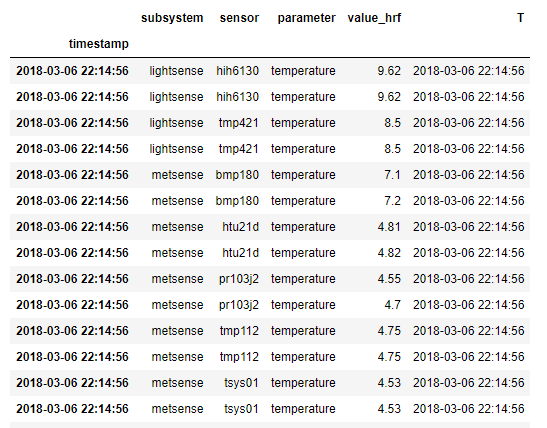

In [81]:

temp_df.drop(['parameter'], axis=1, inplace=True)


C:\Users\tbresee\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [82]:
temp_df.dtypes

subsystem            object
sensor               object
value_hrf            object
T            datetime64[ns]
dtype: object

In [83]:

# temp_df.drop('parameter', axis=1, inplace=True)


In [84]:

temp_df.head(10)


,subsystem,sensor,value_hrf,T
timestamp,,,,
2018-03-06 22:14:56,lightsense,hih6130,9.62,2018-03-06 22:14:56
2018-03-06 22:14:56,lightsense,hih6130,9.62,2018-03-06 22:14:56
2018-03-06 22:14:56,lightsense,tmp421,8.5,2018-03-06 22:14:56
2018-03-06 22:14:56,lightsense,tmp421,8.5,2018-03-06 22:14:56
2018-03-06 22:14:56,metsense,bmp180,7.1,2018-03-06 22:14:56
2018-03-06 22:14:56,metsense,bmp180,7.2,2018-03-06 22:14:56
2018-03-06 22:14:56,metsense,htu21d,4.81,2018-03-06 22:14:56
2018-03-06 22:14:56,metsense,htu21d,4.82,2018-03-06 22:14:56
2018-03-06 22:14:56,metsense,pr103j2,4.55,2018-03-06 22:14:56


In [85]:

temp_df.index


DatetimeIndex(['2018-03-06 22:14:56', '2018-03-06 22:14:56',
               '2018-03-06 22:14:56', '2018-03-06 22:14:56',
               '2018-03-06 22:14:56', '2018-03-06 22:14:56',
               '2018-03-06 22:14:56', '2018-03-06 22:14:56',
               '2018-03-06 22:14:56', '2018-03-06 22:14:56',
               ...
               '2021-03-22 05:18:17', '2021-03-22 05:18:17',
               '2021-03-22 05:18:17', '2021-03-22 05:18:42',
               '2021-03-22 05:18:42', '2021-03-22 05:18:42',
               '2021-03-22 05:18:42', '2021-03-22 05:18:42',
               '2021-03-22 05:18:42', '2021-03-22 05:18:42'],
              dtype='datetime64[ns]', name='timestamp', length=24180875, freq=None)

In [86]:

# import matplotlib.pyplot as plt
# plt.figure(figsize = (19,8))

# import seaborn as sns
# sns.set_theme(style="darkgrid")

# sns.lineplot(x="T", 
#              y="value_hrf",
#              data=temp_df)


<br>

<br>

# Time Filtering

> you can filter for a very short period of time, but also plot out like all of the parameter values for temp or all parameters in general !  A very short timeframe will help you focus and keep size small...

> You also should focus on developing via altair the below diagram for a timeframe of your choice !  Look at the altair templates for this

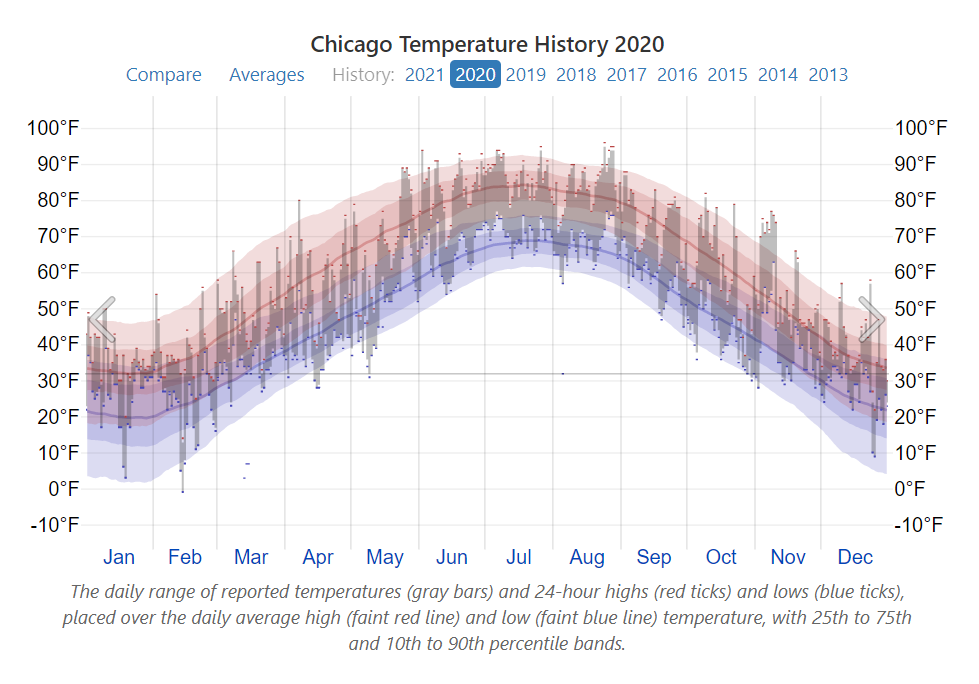

In [ ]:
# single_year = temp_df.copy()
# single_year = single_year[single_year['sensor']=='bmp180']
# single_year = single_year.loc['2019-01-01':'2019-12-31']

In [ ]:

# import seaborn as sns
# plt.figure(figsize = (19,20))
# sns.lineplot(y =  single_year.value_hrf.values,  
#              x  = single_year.index.values);


In [ ]:

# ax = single_year.value_hrf.plot(marker='o', linestyle='-')
# ax.set_ylabel('Daily Consumption (GWh)');


In [ ]:

# type(single_year['value_hrf'].head(10))
# single_year['value_hrf'] = pd.to_numeric(single_year['value_hrf'])


In [ ]:

# from pandas import read_csv
# from matplotlib import pyplot
# single_year['value_hrf'].plot()
# plt.show();

#  single_year['value_hrf'].plot(linewidth=0.5);


In [ ]:


# import seaborn as sns

# plt.figure(figsize = (19,20))

# sns.lineplot(y =  single_year.value_hrf.values,  
#              x  = single_year.index.values);

# # Using plotly.express
# import plotly.express as px

# fig = px.line(single_year, x='T', y="value_hrf")
# fig.show()


In [40]:

# diff_year = temp_df.copy()
# diff_year = diff_year[diff_year['sensor']=='bmp180']
# diff_year = diff_year.loc['2018-09-01':'2019-09-01']


In [41]:

# # Using plotly.express
# import plotly.express as px
# fig = px.line(diff_year, x='T', y="value_hrf")
# fig.show()


In [42]:

# import plotly.express as px
# df = px.data.stocks(indexed=True)-1
# fig = px.area(df, facet_col="company", facet_col_wrap=2)
# fig.show()


In [43]:

# import dash
# import dash_core_components as dcc
# import dash_html_components as html
# from dash.dependencies import Input, Output
# import plotly.express as px

# df = px.data.stocks()

# app = dash.Dash(__name__)

# app.layout = html.Div([
#     dcc.Dropdown(
#         id="ticker",
#         options=[{"label": x, "value": x} 
#                  for x in df.columns[1:]],
#         value=df.columns[1],
#         clearable=False,
#     ),
#     dcc.Graph(id="time-series-chart"),
# ])

# @app.callback(
#     Output("time-series-chart", "figure"), 
#     [Input("ticker", "value")])
# def display_time_series(ticker):
#     fig = px.line(df, x='date', y=ticker)
#     return fig

# app.run_server(debug=True)


In [44]:

# import plotly.express as px
# df = px.data.stocks(indexed=True)-1
# fig = px.area(df, facet_col="company", facet_col_wrap=2)
# fig.show()


In [45]:

# Using plotly.express
# import plotly.express as px
# df = px.data.stocks()
# fig = px.line(df, x='date', y="GOOG")
# fig.show()


In [47]:
# import plotly.express as px
# df = px.data.stocks(indexed=True)-1
# fig = px.area(df, facet_col="company", facet_col_wrap=2)
# fig.show()

In [46]:

# import plotly.express as px
# df = px.data.stocks(indexed=True)-1
# fig = px.area(df, facet_col="company", facet_col_wrap=2)
# fig.show()


In [ ]:

# import plotly.express as px
# fig = px.line(temp_df, x='T', y="value_hrf") #, facet_col="sensor", facet_col_wrap=2)
# fig.show()


In [ ]:

# sns.lineplot(x='T', y='value_hrf', hue='sensor', data=temp_df)


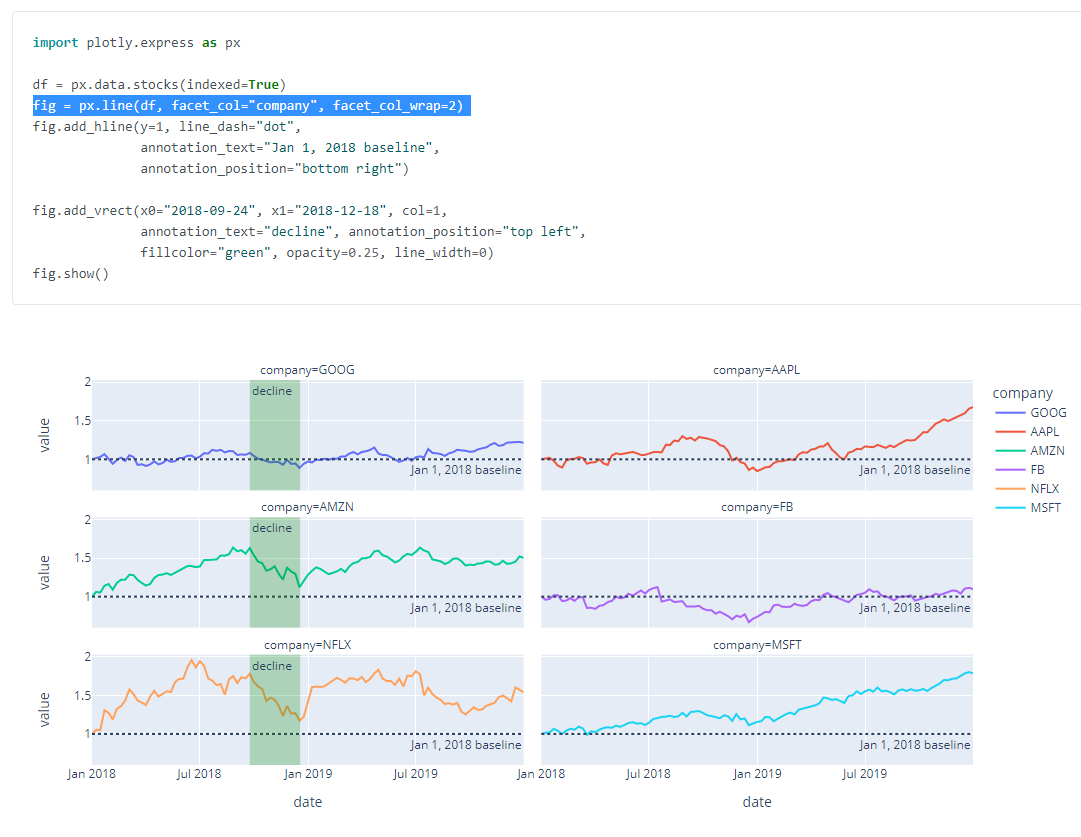

In [48]:
# axes = single_year['value_hrf'].plot(marker='.', 
#                                   alpha=0.5, 
#                                   linestyle='None', 
#                                   figsize=(11, 9), 
#                                   subplots=True)

# for ax in axes:
#     ax.set_ylabel('Daily Totals')

In [ ]:
# plt.figure(figsize = (19,8))

# sns.lineplot(y =  temp_df.loc['2020-01-01':'2020-12-31'].value_hrf,  
#              x  = time_series_df.loc['2020-01-01':'2020-12-31'].index.values);


In [ ]:

# plt.figure(figsize = (19,8))

# sns.lineplot(y =  temp_df.loc['2020-01-01':'2020-12-31'].value_hrf,  
#              x  = time_series_df.loc['2020-01-01':'2020-12-31'].index.values);


In [ ]:

# you can filter as deep as you want fyi: 

# tempo = df[ (df['node_id']=='001e0610ee36') & (df['sensor']=='hih6130') & (df['parameter']=='temperature') & (df['subsystem']=='lightsense') ]

# if you 'compute' this, it will then be a pandas df, and then you can export...


In [ ]:

# type(filtered_df.index)
# output:  pandas.core.indexes.datetimes.DatetimeIndex


In [ ]:

# i do now have the index sorted by timestamp, and showing as datetime index, which is good...


In [ ]:
# df.plot(figsize=(15,4))
# df.plot(subplots=True, figsize=(15,6))
# df.plot(y=["R", "F10.7"], figsize=(15,4))
# df.plot(x="R", y=["F10.7", "Dst"], style='.')

In [49]:

# time_series_df = filtered_df['value_hrf']
# time_series_df.head(10)


In [ ]:

# time_series_df.plot(x="index", y="value_hrf"); 


In [ ]:

# time_series_df.plot(); 


In [ ]:

# time_series_df.loc['2020-01-01':'2020-02-01'].head(100)

# possible reading in the data messed it up ????


In [ ]:

# time_series_df.loc['2019-09-01':'2019-09-02'].head(100)


In [ ]:
# time_series_df.loc['2019-09-01':'2019-09-02'].plot(); 

In [50]:

# time_series_df.loc['2020-06-01':'2021-02-14'].plot(); 


In [ ]:

# overlay the line plot with the true weather seen in the area !  these are outdoor units ! 


In [ ]:

# time_series_df.index[:300]


In [ ]:
# time_series_df[:500].values

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set_theme(style="darkgrid")
# x = time_series_df.index[20000:20050]
# # loc['2020-06-01':'2021-02-14']
# y = time_series_df[:500].values

# sns.lineplot(x,y)
# plt.show(); 

In [ ]:

# time_series_df.loc['2020-06-01':'2021-02-14'].plot(); 


In [51]:

# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# plt.figure(figsize = (15,8))

# # time_series_df.loc['2019-10-01':'2019-10-05'].plot(); 

# sns.lineplot(y = time_series_df.loc['2021-01-01':'2021-01-05'] ,
#              x  = time_series_df.loc['2021-01-01':'2021-01-05'].index.values); 



In [53]:

# plt.figure(figsize = (15,8))
# sns.lineplot(y = time_series_df.loc['2021-01-01':'2021-01-25'] , x  = time_series_df.loc['2021-01-01':'2021-01-25'].index.values); 


In [52]:

# plt.figure(figsize = (15,8))
# sns.lineplot(y = time_series_df.loc['2020-06-01':'2021-01-25'] , 
#              x  = time_series_df.loc['2020-06-01':'2021-01-25'].index.values);


In [ ]:

# plt.figure(figsize = (15,8))
# sns.lineplot(y = time_series_df.loc['2021-01-01':'2021-01-10'].values , 
#              x  = time_series_df.loc['2021-01-01':'2021-01-10'].index.values);


In [ ]:

# plt.figure(figsize = (19,8))
# sns.lineplot(y =  time_series_df.loc['2020-09-18':'2021-02-13'].values , 
#              x  = time_series_df.loc['2020-09-18':'2021-02-13'].index.values);


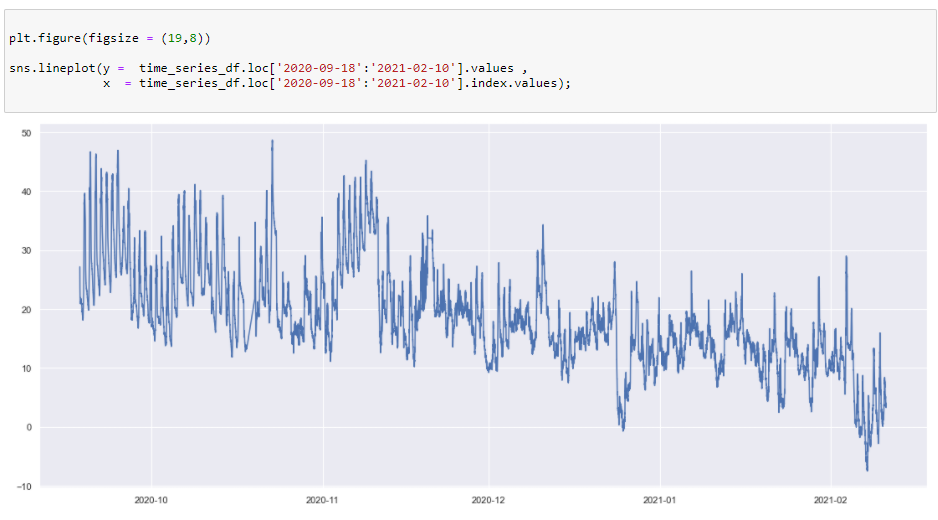

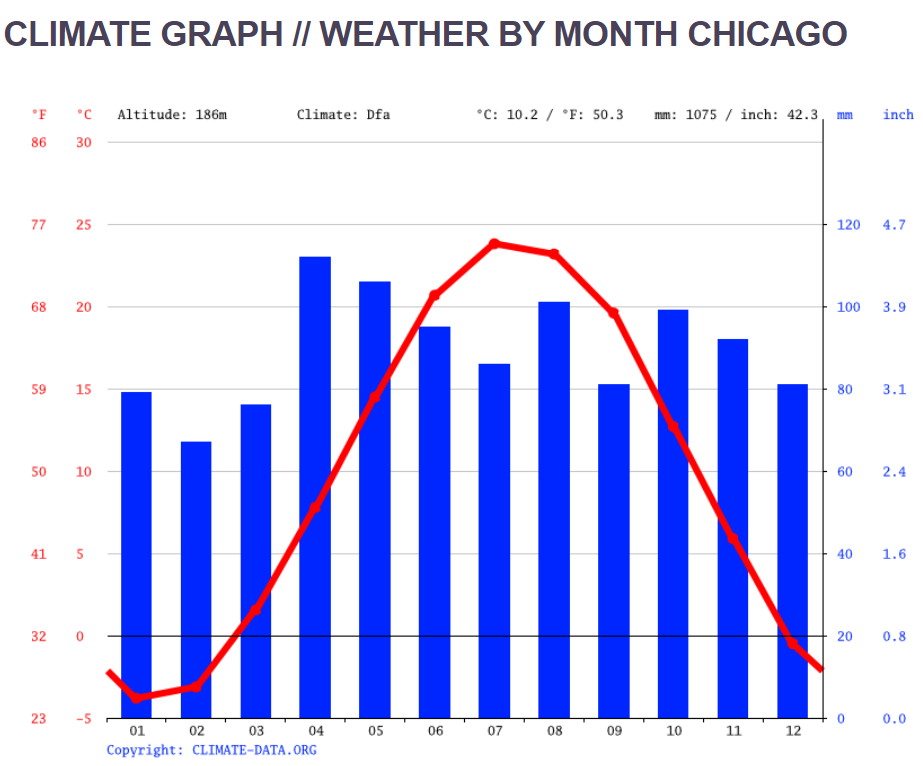

In [ ]:

plt.figure(figsize = (19,8))

sns.lineplot(y =  time_series_df.loc['2020-06-18':'2020-12-30'].values , 
             x  = time_series_df.loc['2020-06-18':'2020-12-30'].index.values);


#### 2020 Weather Temp - Chicago 

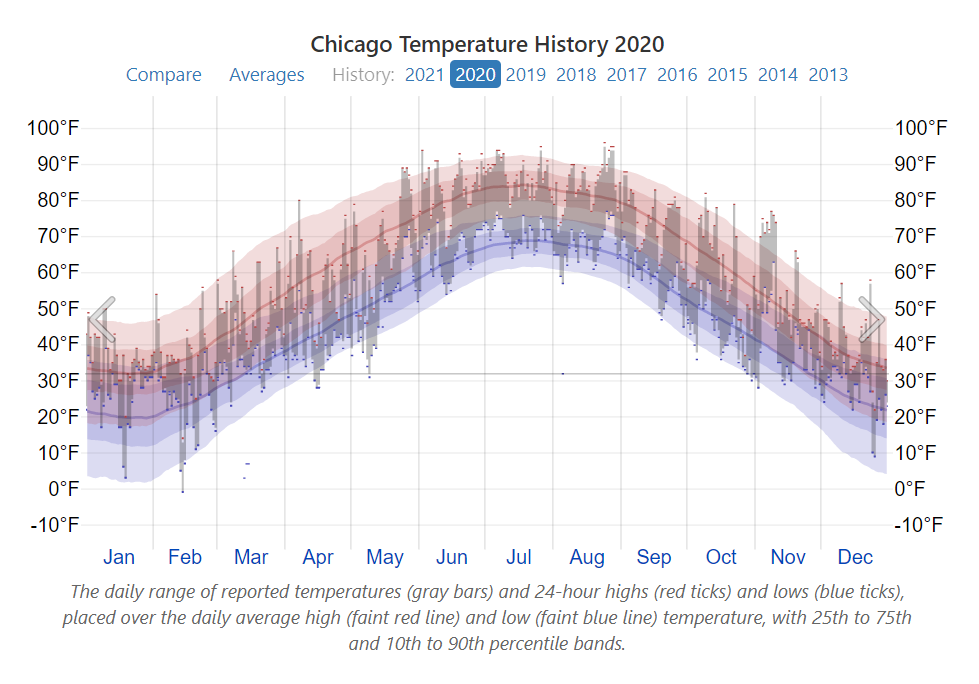

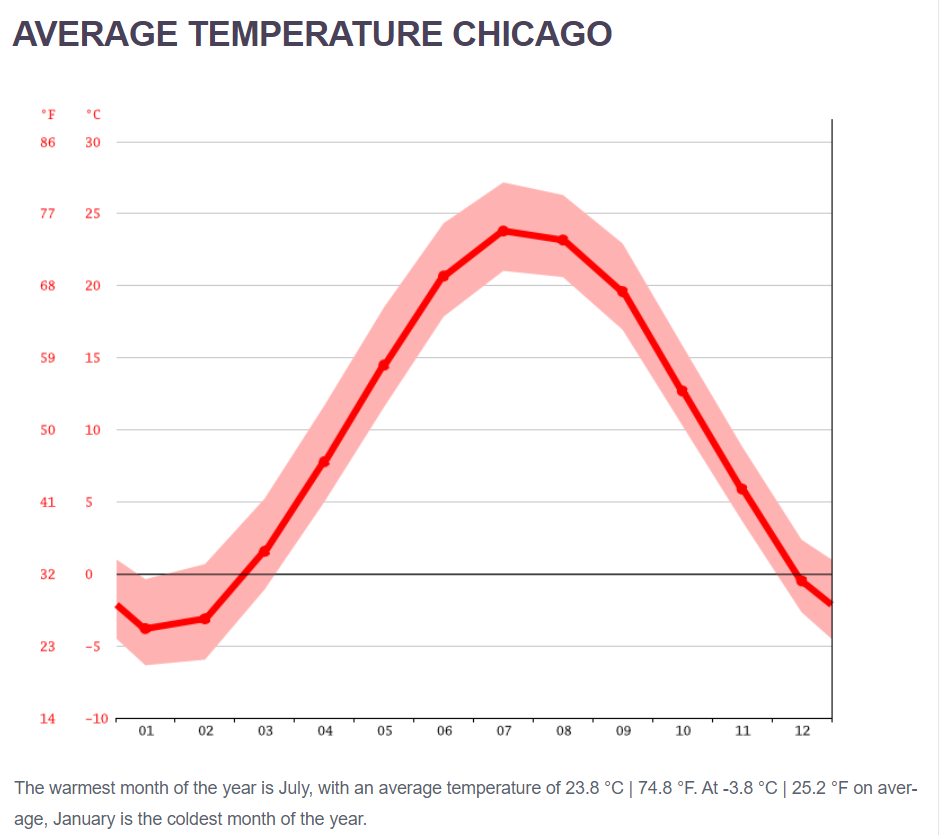

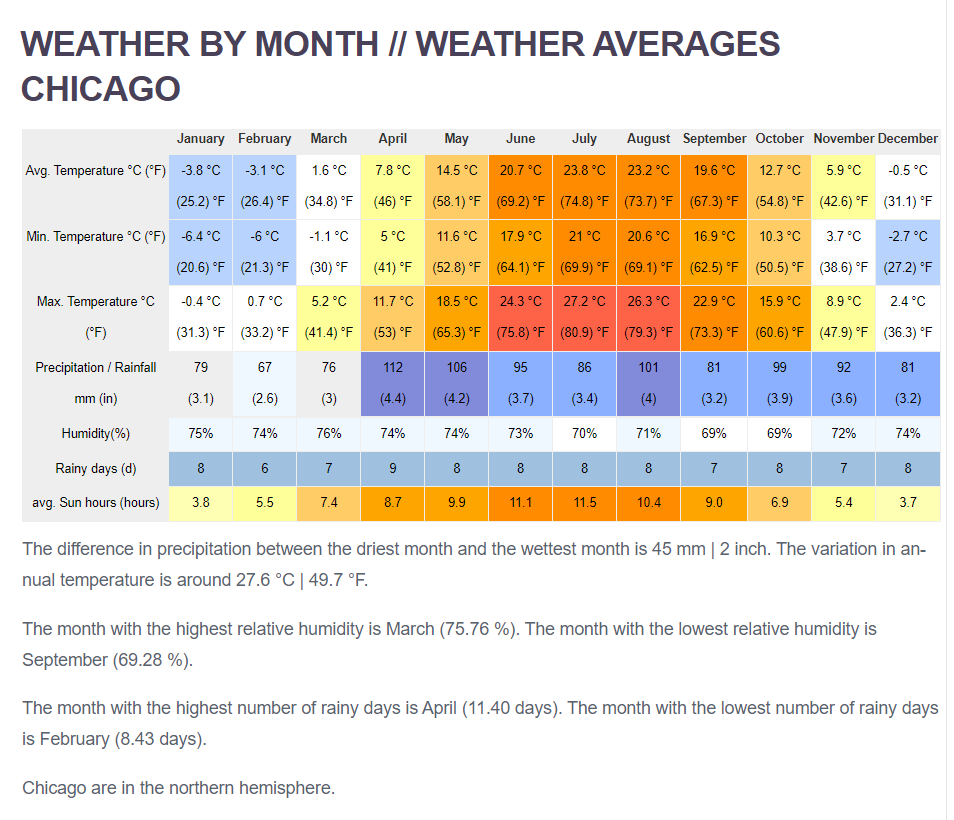

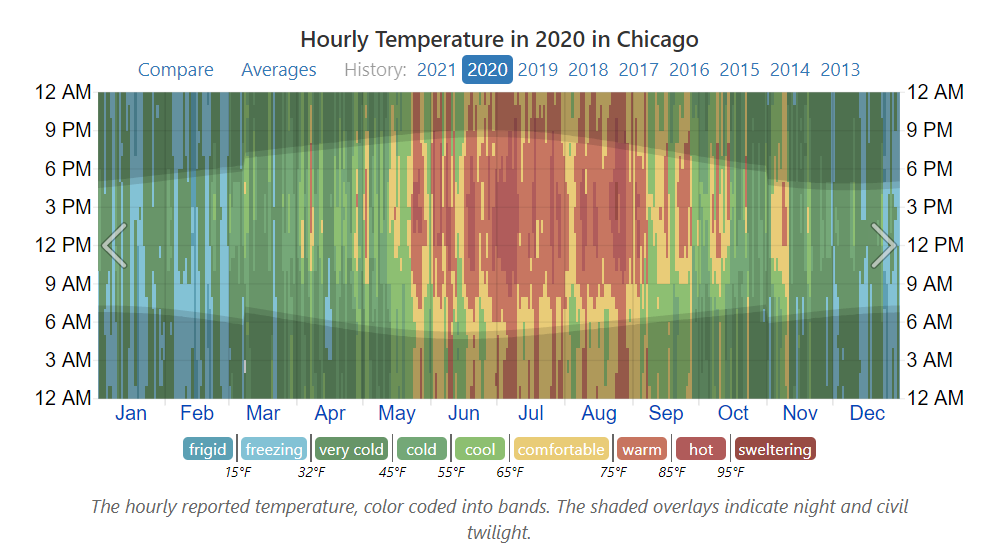

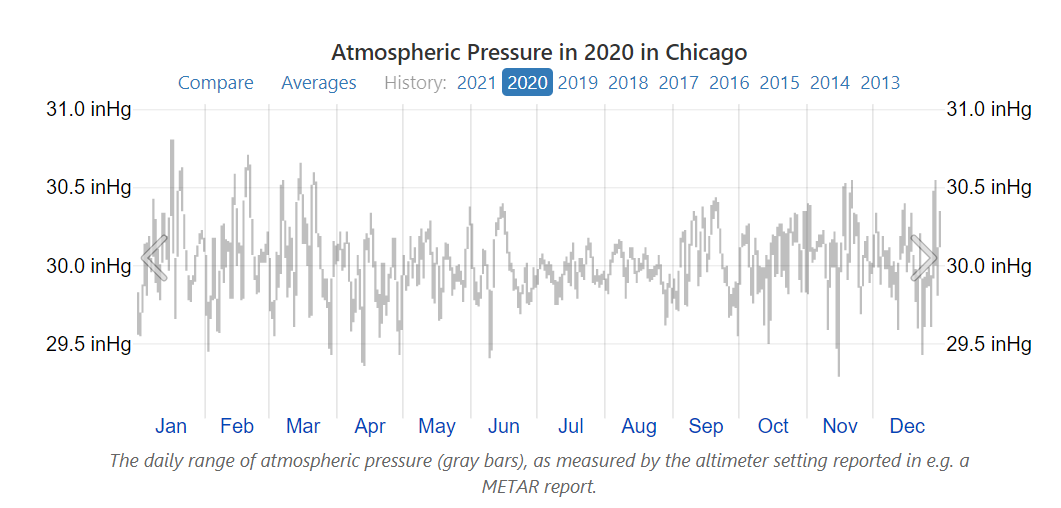

In [ ]:

# for some reason taking a count() or len takes foreverrrr 
# temp_df.count()


In [ ]:

# issues ? ? ? 
# temp_df = df[ (df['sensor']=='hih6130') & (df['node_id']=='001e0610e532') & (df['subsystem']=='lightsense2') & (df['parameter']=='temperature') ].compute()
# temp_df.head()


In [ ]:

#  df.isnull().sum().compute()
# df[df.quantity < 10].compute()


In [38]:

# can get fancy if you want to
#  df[ (df['sensor']=='hih6130') & (df['node_id']=='001e0610e532') & (df['subsystem']=='lightsense2') & (df['parameter']=='temperature') ].head(10)


In [54]:

# me = df[ (df['sensor']=='hih6130') & (df['node_id']=='001e0610e532') & (df['parameter']=='temperature') ].compute()
# rslt_df = dataframe[(dataframe['Age'] == 21) &
#           dataframe['Stream'].isin(options)]



* https://github.com/dask/dask-tutorial/blob/main/07_dataframe_storage.ipynb
* https://github.com/dask/dask-tutorial
    